# Network Science Project - Analysis of Sports Facilities in Estonia

## Purpose
This notebook presents the analysis conducted as part of a Network Science course project. The primary focus is on data manipulation and network analysis to derive meaningful insights from the dataset.

## Structure
- **Initial Setup**: Import necessary libraries and set up the environment for analysis.
- **Data Loading**: Load two datasets containing data about sports facilities and sports organizations in Estonia.
- **Data Preprocessing**: Convert columns to correct formats, process numerical data, and prepare the data for network analysis.

## Goals
- To understand the connections and relationships within the data.
- To apply network science methodologies to uncover patterns and insights.

## Data Sources
- JSON files from Eesti spordiregister (Estonian Sports Register)

## Preprocessing

### Sports Facilities dataset

In [43]:
import json
import pandas as pd
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from pyvis.network import Network
from networkx.algorithms import bipartite

data = pd.read_json('spordiehitised.json')

# Parse the JSON-like string and extract information
def extract_info(json_str):
    try:
        if not isinstance(json_str, str):
            json_str = str(json_str)
        json_str = json_str.replace("'", '"').replace('\\', '\\\\')

        data_dict = json.loads(json_str)
        first_key = list(data_dict.keys())[0]
        info = data_dict[first_key]
        
        # Extract required fields
        objektid = info.get('objektid', '')
        objektnimi = info.get('objektnimi', '')
        tehnseisukord = info.get('tehnseisukord', '')
        
        # Extract 'spordialad', handling nested dictionary keys
        spordialad_keys = info.get('spordialad', {}).keys()
        spordialad = ', '.join([info['spordialad'][key].get('spordiala', '') for key in spordialad_keys])
        
        return pd.Series([objektid, objektnimi, tehnseisukord, spordialad])
    except Exception as e:
        # Log error details
        with open('error_log.txt', 'a') as f:
            f.write(f"Error processing JSON: {e} - Data: {json_str[:100]}\n")
        return pd.Series([None, None, None, None])

# Define new columns
new_columns = ['objektid', 'objektnimi', 'tehnseisukord', 'spordialad']
data[new_columns] = pd.DataFrame(columns=new_columns)  # Initialize the new columns

data[new_columns] = data['paigad'].apply(extract_info)

# Remove unnecessary columns
columns_to_keep = [
    'rajatisid', 'rajatisnimi', 'kompleks', 'liik', 'omandiliik', 'ehstaatus',
    'om_oigvorm_id', 'omaniknimi', 'omanikregkood', 'va_oigvorm_id',
    'valdajanimi', 'valdajaregkood', 'kaart_laius', 'kaart_pikkus', 'maakond',
    'maakond_kood', 'kov', 'asustusyksus', 'asustusyksus_kood', 'riietusruumidemahutavus',
    'objektid', 'objektnimi', 'tehnseisukord', 'spordialad'
]

data = data[columns_to_keep]
data.to_csv('facilities.csv', index=False)

# Work with CSV file
processed_data = pd.read_csv('facilities.csv')

# Convert all string columns to lowercase
processed_data = processed_data.apply(lambda x: x.str.lower() if x.dtype == "object" else x)
# Fill NaN values with '0'
processed_data = processed_data.fillna(0)

# Convert columns
for column in processed_data.columns:
    if processed_data[column].dtype == 'object':
        processed_data[column] = processed_data[column].astype(str)
columns_to_int = [
    'omanikregkood', 'valdajaregkood', 'maakond_kood', 'asustusyksus_kood', 'riietusruumidemahutavus',
    'objektid'
]
for column in columns_to_int:
    processed_data[column] = pd.to_numeric(processed_data[column], errors='coerce').fillna(0).astype(int)

In [8]:
processed_data.head()

rajatisid               rajatisnimi kompleks  \
0       5221        24-7 fitness pärnu        0   
1       5585         24-7fitness avala        0   
2       4910    24-7fitness kuressaare        0   
3       4890          24-7fitness laki        0   
4       4892  24-7fitness mustamäe tee        0   

                             liik omandiliik               ehstaatus  \
0  võimla, spordihall, spordisaal  kinnisasi  spordialases kasutuses   
1  võimla, spordihall, spordisaal  kinnisasi  spordialases kasutuses   
2  võimla, spordihall, spordisaal  kinnisasi  spordialases kasutuses   
3  võimla, spordihall, spordisaal  kinnisasi  spordialases kasutuses   
4  võimla, spordihall, spordisaal  kinnisasi  spordialases kasutuses   

  om_oigvorm_id                     omaniknimi  omanikregkood va_oigvorm_id  \
0      osaühing               oü triple invest       10250206      osaühing   
1   aktsiaselts  aktsiaselts kaamos kinnisvara       10886401      osaühing   
2      osaühing                oü tulik invest       11449200      osaühing   
3      osaühing                 laki põik 4 oü       12943304      osaühing   
4   aktsiaselts      aktsiaselts eesti talleks       10280727      osaühing   

   ...   maakond  maakond_kood       kov        asustusyksus  \
0  ...  pärnumaa            68     pärnu          pärnu linn   
1  ...  harjumaa            37   tallinn  kesklinna linnaosa   
2  ...  saaremaa            74  saaremaa     kuressaare linn   
3  ...  harjumaa            37   tallinn   mustamäe linnaosa   
4  ...  harjumaa            37   tallinn  kristiine linnaosa   

  asustusyksus_kood  riietusruumidemahutavus objektid  \
0              6619                      235    10849   
1               298                      185    11527   
2              3655                      128    10320   
3               482                      200    10315   
4               339                      220    10288   

                       objektnimi  tehnseisukord  \
0                         jõusaal       väga hea   
1                   aeroobikasaal       väga hea   
2  24-7fitness kuressaare jõusaal       väga hea   
3                         jõusaal       väga hea   
4                         jõusaal       väga hea   

                                          spordialad  
0      jõutõstmine, kulturism ja fitness, tõstesport  
1  aeroobika ja rühmatreeningud, harrastusvõimlemine  
2      jõutõstmine, kulturism ja fitness, tõstesport  
3      jõutõstmine, kulturism ja fitness, tõstesport  
4  jõutõstmine, kulturism ja fitness, tõstesport,...  

[5 rows x 24 columns]

In [9]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3906 entries, 0 to 3905
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   rajatisid                3906 non-null   int64  
 1   rajatisnimi              3906 non-null   object 
 2   kompleks                 3906 non-null   object 
 3   liik                     3906 non-null   object 
 4   omandiliik               3906 non-null   object 
 5   ehstaatus                3906 non-null   object 
 6   om_oigvorm_id            3906 non-null   object 
 7   omaniknimi               3906 non-null   object 
 8   omanikregkood            3906 non-null   int64  
 9   va_oigvorm_id            3906 non-null   object 
 10  valdajanimi              3906 non-null   object 
 11  valdajaregkood           3906 non-null   int64  
 12  kaart_laius              3906 non-null   float64
 13  kaart_pikkus             3906 non-null   float64
 14  maakond                 

### Sports Organisations dataset

In [10]:
# data_org = pd.read_json('spordiorganisatsioonid.json')
# columns_to_keep_org = [
#     'org_id', 'nimi', 'registrikood', 'maakond', 'maakond_kood', 'kov', 'kov_kood', 'kaart_laius', 'kaart_pikkus'
# ]
# data_org = data_org[columns_to_keep_org]

# data_org.to_csv('spordiorganisatsioonid.csv')

# # Work with CSV file
# processed_data_org = pd.read_csv('spordiorganisatsioonid.csv')

# # Convert all string columns to lowercase
# processed_data_org = processed_data_org.apply(lambda x: x.str.lower() if x.dtype == "object" else x)
# # Fill NaN values with '0'
# processed_data_org = processed_data_org.fillna(0)

# # Convert columns
# for column in processed_data_org.columns:
#     if processed_data_org[column].dtype == 'object':
#         processed_data_org[column] = processed_data_org[column].astype(str)
# columns_to_int_org = [
#     'registrikood', 'maakond_kood', 'kov_kood'
# ]

# for column in columns_to_int_org:
#     processed_data_org[column] = pd.to_numeric(processed_data_org[column], errors='coerce').fillna(0).astype(int)

In [44]:
# Load the JSON data
with open('spordiorganisatsioonid.json') as f:
    data_org = json.load(f)

# Parse the JSON data to extract relevant information
organizations = []
activity_locations = []
sports = []

for item in data_org:
    org_id = item['org_id']
    org_name = item['nimi']
    registrikood = item['registrikood']
    maakond = item['maakond']
    maakond_kood = item['maakond_kood']
    kov = item['kov']
    kov_kood = item['kov_kood']
    kaart_laius = item['kaart_laius']
    kaart_pikkus = item['kaart_pikkus']
    
    sports_list = []
    if 'sport' in item:
        for sport in item['sport'].values():
            sports_list.append(sport['spordiala'])
            if 'tegutsemispaigad' in sport and isinstance(sport['tegutsemispaigad'], dict):
                for location_key, location in sport['tegutsemispaigad'].items():
                    activity_locations.append({
                        'org_id': org_id,
                        'location_name': location['nimi'],
                        'location_address': location['aadress']
                    })
            sports.append(sport['spordiala'])

    organizations.append({
        'org_id': org_id,
        'nimi': org_name,
        'registrikood': registrikood,
        'maakond': maakond,
        'maakond_kood': maakond_kood,
        'kov': kov,
        'kov_kood': kov_kood,
        'kaart_laius': kaart_laius,
        'kaart_pikkus': kaart_pikkus,
        'sports': ', '.join(sports_list)  # Combine sports into a single string
    })

# Convert to DataFrame
df_organizations = pd.DataFrame(organizations)
df_activity_locations = pd.DataFrame(activity_locations)

# Merge activity locations with organizations
df_merged = pd.merge(df_organizations, df_activity_locations, on='org_id', how='left')

# Convert all string columns to lowercase
processed_data_org = df_merged.apply(lambda x: x.str.lower() if x.dtype == "object" else x)
# Fill NaN values with '0'
processed_data_org = processed_data_org.fillna(0)

# Convert columns to appropriate types
for column in processed_data_org.columns:
    if processed_data_org[column].dtype == 'object':
        processed_data_org[column] = processed_data_org[column].astype(str)

columns_to_int_org = ['registrikood', 'maakond_kood', 'kov_kood']
for column in columns_to_int_org:
    processed_data_org[column] = pd.to_numeric(processed_data_org[column], errors='coerce').fillna(0).astype(int)

# Save the processed data
processed_data_org.to_csv('organizations.csv', index=False)

# Extract unique sports
unique_sports = list(set(sports))
unique_sports_df = pd.DataFrame(unique_sports, columns=['spordiala'])

# Save unique sports to a CSV file for further processing if needed
unique_sports_df.to_csv('unique_sports.csv', index=False)


In [5]:
processed_data_org.head()

org_id                           nimi  registrikood   maakond  maakond_kood  \
0   7065            #26 racing team mtü      80580106  harjumaa            37   
1   5948  #teampinkpurple disc golf mtü      80409045   hiiumaa            39   
2   5403                   & moments oü      11675818  harjumaa            37   
3   7258            24-7fitnessklubi oü      14045006  harjumaa            37   
4   7258            24-7fitnessklubi oü      14045006  harjumaa            37   

       kov  kov_kood      kaart_laius     kaart_pikkus  \
0     kose       338  59.200119943764   25.10618680465   
1  hiiumaa       205  58.999830604063  22.729827811749   
2  tallinn       784                                     
3  tallinn       784  59.411224815176  24.671721206262   
4  tallinn       784  59.411224815176  24.671721206262   

                             sports  \
0                                     
1                  lennuketta sport   
2                                     
3  kulturism ja fitness, võimlemine   
4  kulturism ja fitness, võimlemine   

                                 location_name  \
0                                            0   
1  paluküla tervisespordikeskuse liikumisrajad   
2                                            0   
3                           24-7 fitness pärnu   
4                            24-7fitness avala   

                                    location_address  
0                                                  0  
1  suusamäe, hausma küla, hiiumaa vald, hiiu maakond  
2                                                  0  
3   lai tn 11, pärnu linn, pärnu linn, pärnu maakond  
4  veskiposti tn 2, kesklinna linnaosa, tallinn, ...

In [6]:
processed_data_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6602 entries, 0 to 6601
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   org_id            6602 non-null   object
 1   nimi              6602 non-null   object
 2   registrikood      6602 non-null   int64 
 3   maakond           6602 non-null   object
 4   maakond_kood      6602 non-null   int64 
 5   kov               6602 non-null   object
 6   kov_kood          6602 non-null   int64 
 7   kaart_laius       6602 non-null   object
 8   kaart_pikkus      6602 non-null   object
 9   sports            6602 non-null   object
 10  location_name     6602 non-null   object
 11  location_address  6602 non-null   object
dtypes: int64(3), object(9)
memory usage: 619.1+ KB


In [45]:
filtered_data_org = processed_data_org[(processed_data_org['location_name'].notna()) & (processed_data_org['location_name'] != '0')]

In [46]:
### CHOOSE SPORTS
# sports = 'jalgpall'
# #condition = 'väga hea'


# # Filter processed_data_org where 'sports' contains 'jalgpall'
# filtered_data_org = filtered_data_org[filtered_data_org['sports'].str.contains(sports, case=False, na=False)]

# # Filter processed_data where 'spordialad' contains 'jalgpall'
# filtered_data_fac = processed_data[
#     processed_data['spordialad'].str.contains(sports, case=False, na=False) #& 
#     #processed_data['tehnseisukord'].str.contains(condition, case=False, na=False)
# ]

filtered_data_org = filtered_data_org
filtered_data_fac = processed_data

# Load and display the first few rows of each filtered dataset to verify
filtered_data_org.head(), filtered_data_fac.head()


(  org_id                           nimi  registrikood   maakond  maakond_kood  \
 1   5948  #teampinkpurple disc golf mtü      80409045   hiiumaa            39   
 3   7258            24-7fitnessklubi oü      14045006  harjumaa            37   
 4   7258            24-7fitnessklubi oü      14045006  harjumaa            37   
 5   7258            24-7fitnessklubi oü      14045006  harjumaa            37   
 6   7258            24-7fitnessklubi oü      14045006  harjumaa            37   
 
        kov  kov_kood      kaart_laius     kaart_pikkus  \
 1  hiiumaa       205  58.999830604063  22.729827811749   
 3  tallinn       784  59.411224815176  24.671721206262   
 4  tallinn       784  59.411224815176  24.671721206262   
 5  tallinn       784  59.411224815176  24.671721206262   
 6  tallinn       784  59.411224815176  24.671721206262   
 
                              sports  \
 1                  lennuketta sport   
 3  kulturism ja fitness, võimlemine   
 4  kulturism ja fitness, võim

In [47]:
filtered_data_fac

rajatisid                                 rajatisnimi         kompleks  \
0          5221                          24-7 fitness pärnu                0   
1          5585                           24-7fitness avala                0   
2          4910                      24-7fitness kuressaare                0   
3          4890                            24-7fitness laki                0   
4          6072                           24-7fitness luige                0   
...         ...                                         ...              ...   
4066       5280                       ääsmäe discgolfi park                0   
4067       1749                   ääsmäe küla mänguväljakud                0   
4068       1750                       ääsmäe küla skatepark                0   
4069       2863  ääsmäe põhikooli staadion ja palliväljakud  ääsmäe põhikool   
4070       1745          ääsmäe põhikooli võimla ja jõusaal  ääsmäe põhikool   

                                  liik omandiliik               ehstaatus  \
0       võimla, spordihall, spordisaal  kinnisasi  spordialases kasutuses   
1       võimla, spordihall, spordisaal  kinnisasi  spordialases kasutuses   
2       võimla, spordihall, spordisaal  kinnisasi  spordialases kasutuses   
3       võimla, spordihall, spordisaal  kinnisasi  spordialases kasutuses   
4       võimla, spordihall, spordisaal  kinnisasi  spordialases kasutuses   
...                                ...        ...                     ...   
4066  muu vabas õhus asuv spordiobjekt        muu  spordialases kasutuses   
4067                  välispalliväljak  kinnisasi  spordialases kasutuses   
4068                   muu spordiplats  kinnisasi  spordialases kasutuses   
4069        staadion, välispalliväljak  kinnisasi  spordialases kasutuses   
4070    võimla, spordihall, spordisaal  kinnisasi  spordialases kasutuses   

                    om_oigvorm_id                     omaniknimi  \
0                        osaühing               oü triple invest   
1                     aktsiaselts  aktsiaselts kaamos kinnisvara   
2                        osaühing                oü tulik invest   
3                        osaühing                 laki põik 4 oü   
4                        osaühing             luige ärikeskus oü   
...                           ...                            ...   
4066           mittetulundusühing                ääsmäe külakogu   
4067  kohaliku omavalitsuse üksus             saue vallavalitsus   
4068  kohaliku omavalitsuse üksus             saue vallavalitsus   
4069  kohaliku omavalitsuse üksus             saue vallavalitsus   
4070  kohaliku omavalitsuse üksus             saue vallavalitsus   

      omanikregkood                va_oigvorm_id  ...   maakond  maakond_kood  \
0          10250206                     osaühing  ...  pärnumaa            68   
1          10886401                     osaühing  ...  harjumaa            37   
2          11449200                     osaühing  ...  saaremaa            74   
3          12943304                     osaühing  ...  harjumaa            37   
4          16335062                     osaühing  ...  harjumaa            37   
...             ...                          ...  ...       ...           ...   
4066       80018304           mittetulundusühing  ...  harjumaa            37   
4067       77000430                   sihtasutus  ...  harjumaa            37   
4068       77000430  kohaliku omavalitsuse üksus  ...  harjumaa            37   
4069       77000430  kohaliku omavalitsuse üksus  ...  harjumaa            37   
4070       77000430  kohaliku omavalitsuse üksus  ...  harjumaa            37   

           kov        asustusyksus asustusyksus_kood  riietusruumidemahutavus  \
0        pärnu          pärnu linn              6619                      235   
1      tallinn  kesklinna linnaosa               298                      185   
2     saaremaa     kuressaare linn              3655                      128   
3     

## Network construction

In [8]:
B = nx.Graph()

# Add nodes for organizations with coordinates
for index, row in filtered_data_org.iterrows():
    B.add_node(f'org_{row["org_id"]}', bipartite=1, label=row['nimi'], 
               latitude=row['kaart_laius'], longitude=row['kaart_pikkus'])

# Add nodes for activity locations (facilities)
for index, row in filtered_data_fac.iterrows():
    B.add_node(f'facility_{row["rajatisid"]}', bipartite=0, label=row['rajatisnimi'],
               latitude=row['kaart_laius'], longitude=row['kaart_pikkus'])

# Add edges based on the relationships
for index, row in filtered_data_org.iterrows():
    if pd.notna(row['location_name']):
        org_node = f'org_{row["org_id"]}'
        facility_node_df = filtered_data_fac[filtered_data_fac['rajatisnimi'] == row['location_name']]
        if not facility_node_df.empty:
            facility_node = f'facility_{facility_node_df["rajatisid"].values[0]}'
            B.add_edge(org_node, facility_node)

# Validate the bipartite nature
if bipartite.is_bipartite(B):
    print("The graph is bipartite.")
else:
    print("The graph is not bipartite. Checking for issues...")

# Print number of nodes and edges
print(f"Number of nodes: {B.number_of_nodes()}")
print(f"Number of edges: {B.number_of_edges()}")

# Define the position using bipartite layout
pos = nx.bipartite_layout(B, nodes=[n for n, d in B.nodes(data=True) if d['bipartite'] == 0])

# Visualizing the bipartite graph
plt.figure(figsize=(12, 8))
nx.draw(B, pos, with_labels=True, node_size=300, node_color='lightblue', edge_color='gray', font_size=8)
plt.title("Bipartite Graph of Organizations and Facilities")
plt.show()

The graph is bipartite.
Number of nodes: 852
Number of edges: 455


In [11]:
B = nx.Graph()

# Add nodes for organizations with coordinates
for index, row in filtered_data_org.iterrows():
    B.add_node(f'org_{row["org_id"]}', bipartite=1, label=row['nimi'], 
               latitude=row['kaart_laius'], longitude=row['kaart_pikkus'])

# Add nodes for activity locations (facilities)
for index, row in filtered_data_fac.iterrows():
    B.add_node(f'facility_{row["rajatisid"]}', bipartite=0, label=row['rajatisnimi'],
               latitude=row['kaart_laius'], longitude=row['kaart_pikkus'])

# Add edges based on the relationships
for index, row in filtered_data_org.iterrows():
    if pd.notna(row['location_name']):
        org_node = f'org_{row["org_id"]}'
        facility_node_df = filtered_data_fac[filtered_data_fac['rajatisnimi'] == row['location_name']]
        if not facility_node_df.empty:
            facility_node = f'facility_{facility_node_df["rajatisid"].values[0]}'
            B.add_edge(org_node, facility_node)

# Validate the bipartite nature
if bipartite.is_bipartite(B):
    print("The graph is bipartite.")
else:
    print("The graph is not bipartite. Checking for issues...")

# Print number of nodes and edges
print(f"Number of nodes: {B.number_of_nodes()}")
print(f"Number of edges: {B.number_of_edges()}")

# Visualizing the bipartite graph
# Increase figure size for better visibility
plt.figure(figsize=(40, 30))

# Define the position using bipartite layout
pos = nx.spring_layout(B, seed=42)

# Draw the bipartite graph
nx.draw(B, pos, with_labels=True, node_size=100, font_size=6, node_color='lightblue', edge_color='gray')
plt.title("Bipartite Graph of Organizations and Facilities")
plt.show()

The graph is bipartite.
Number of nodes: 852
Number of edges: 455


In [12]:
# Ensuring correct data types for spordiehitised
filtered_data_fac['rajatisid'] = filtered_data_fac['rajatisid'].astype(int)
filtered_data_fac['kaart_laius'] = filtered_data_fac['kaart_laius'].astype(float)
filtered_data_fac['kaart_pikkus'] = filtered_data_fac['kaart_pikkus'].astype(float)
filtered_data_fac['maakond_kood'] = filtered_data_fac['maakond_kood'].astype(int)
filtered_data_fac['asustusyksus_kood'] = filtered_data_fac['asustusyksus_kood'].astype(int)
filtered_data_fac['riietusruumidemahutavus'] = filtered_data_fac['riietusruumidemahutavus'].astype(int)
filtered_data_fac['objektid'] = filtered_data_fac['objektid'].astype(int)

# Ensuring correct data types for spordiorganisatsioonid
filtered_data_org['org_id'] = filtered_data_org['org_id'].astype(int)
filtered_data_org['kaart_laius'] = filtered_data_org['kaart_laius'].astype(float)
filtered_data_org['kaart_pikkus'] = filtered_data_org['kaart_pikkus'].astype(float)
filtered_data_org['maakond_kood'] = filtered_data_org['maakond_kood'].astype(int)
filtered_data_org['kov_kood'] = filtered_data_org['kov_kood'].astype(int)

# Confirm data types
filtered_data_fac.dtypes, filtered_data_org.dtypes


/var/folders/pp/kqjzr5d14nd29kdklrl2bmgh0000gn/T/ipykernel_69147/753416585.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_fac['rajatisid'] = filtered_data_fac['rajatisid'].astype(int)
/var/folders/pp/kqjzr5d14nd29kdklrl2bmgh0000gn/T/ipykernel_69147/753416585.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_fac['kaart_laius'] = filtered_data_fac['kaart_laius'].astype(float)
/var/folders/pp/kqjzr5d14nd29kdklrl2bmgh0000gn/T/ipykernel_69147/753416585.py:4: SettingWithCopyWarn

(rajatisid                    int64
 rajatisnimi                 object
 kompleks                    object
 liik                        object
 omandiliik                  object
 ehstaatus                   object
 om_oigvorm_id               object
 omaniknimi                  object
 omanikregkood                int64
 va_oigvorm_id               object
 valdajanimi                 object
 valdajaregkood               int64
 kaart_laius                float64
 kaart_pikkus               float64
 maakond                     object
 maakond_kood                 int64
 kov                         object
 asustusyksus                object
 asustusyksus_kood            int64
 riietusruumidemahutavus      int64
 objektid                     int64
 objektnimi                  object
 tehnseisukord               object
 spordialad                  object
 dtype: object,
 org_id                int64
 nimi                 object
 registrikood          int64
 maakond              object
 maa

In [18]:
processed_data

rajatisid                                 rajatisnimi         kompleks  \
0          5221                          24-7 fitness pärnu                0   
1          5585                           24-7fitness avala                0   
2          4910                      24-7fitness kuressaare                0   
3          4890                            24-7fitness laki                0   
4          4892                    24-7fitness mustamäe tee                0   
...         ...                                         ...              ...   
3901       5280                       ääsmäe discgolfi park                0   
3902       1749                   ääsmäe küla mänguväljakud                0   
3903       1750                       ääsmäe küla skatepark                0   
3904       2863  ääsmäe põhikooli staadion ja palliväljakud  ääsmäe põhikool   
3905       1745          ääsmäe põhikooli võimla ja jõusaal  ääsmäe põhikool   

                                  liik omandiliik               ehstaatus  \
0       võimla, spordihall, spordisaal  kinnisasi  spordialases kasutuses   
1       võimla, spordihall, spordisaal  kinnisasi  spordialases kasutuses   
2       võimla, spordihall, spordisaal  kinnisasi  spordialases kasutuses   
3       võimla, spordihall, spordisaal  kinnisasi  spordialases kasutuses   
4       võimla, spordihall, spordisaal  kinnisasi  spordialases kasutuses   
...                                ...        ...                     ...   
3901  muu vabas õhus asuv spordiobjekt        muu  spordialases kasutuses   
3902                  välispalliväljak  kinnisasi  spordialases kasutuses   
3903                   muu spordiplats  kinnisasi  spordialases kasutuses   
3904        staadion, välispalliväljak  kinnisasi  spordialases kasutuses   
3905    võimla, spordihall, spordisaal  kinnisasi  spordialases kasutuses   

                    om_oigvorm_id                     omaniknimi  \
0                        osaühing               oü triple invest   
1                     aktsiaselts  aktsiaselts kaamos kinnisvara   
2                        osaühing                oü tulik invest   
3                        osaühing                 laki põik 4 oü   
4                     aktsiaselts      aktsiaselts eesti talleks   
...                           ...                            ...   
3901           mittetulundusühing                ääsmäe külakogu   
3902  kohaliku omavalitsuse üksus             saue vallavalitsus   
3903  kohaliku omavalitsuse üksus             saue vallavalitsus   
3904  kohaliku omavalitsuse üksus             saue vallavalitsus   
3905  kohaliku omavalitsuse üksus             saue vallavalitsus   

      omanikregkood                va_oigvorm_id  ...   maakond  maakond_kood  \
0          10250206                     osaühing  ...  pärnumaa            68   
1          10886401                     osaühing  ...  harjumaa            37   
2          11449200                     osaühing  ...  saaremaa            74   
3          12943304                     osaühing  ...  harjumaa            37   
4          10280727                     osaühing  ...  harjumaa            37   
...             ...                          ...  ...       ...           ...   
3901       80018304           mittetulundusühing  ...  harjumaa            37   
3902       77000430                   sihtasutus  ...  harjumaa            37   
3903       77000430  kohaliku omavalitsuse üksus  ...  harjumaa            37   
3904       77000430  kohaliku omavalitsuse üksus  ...  harjumaa            37   
3905       77000430  kohaliku omavalitsuse üksus  ...  harjumaa            37   

           kov        asustusyksus asustusyksus_kood  riietusruumidemahutavus  \
0        pärnu          pärnu linn              6619                      235   
1      tallinn  kesklinna linnaosa               298                      185   
2     saaremaa     kuressaare linn              3655                      128   
3     

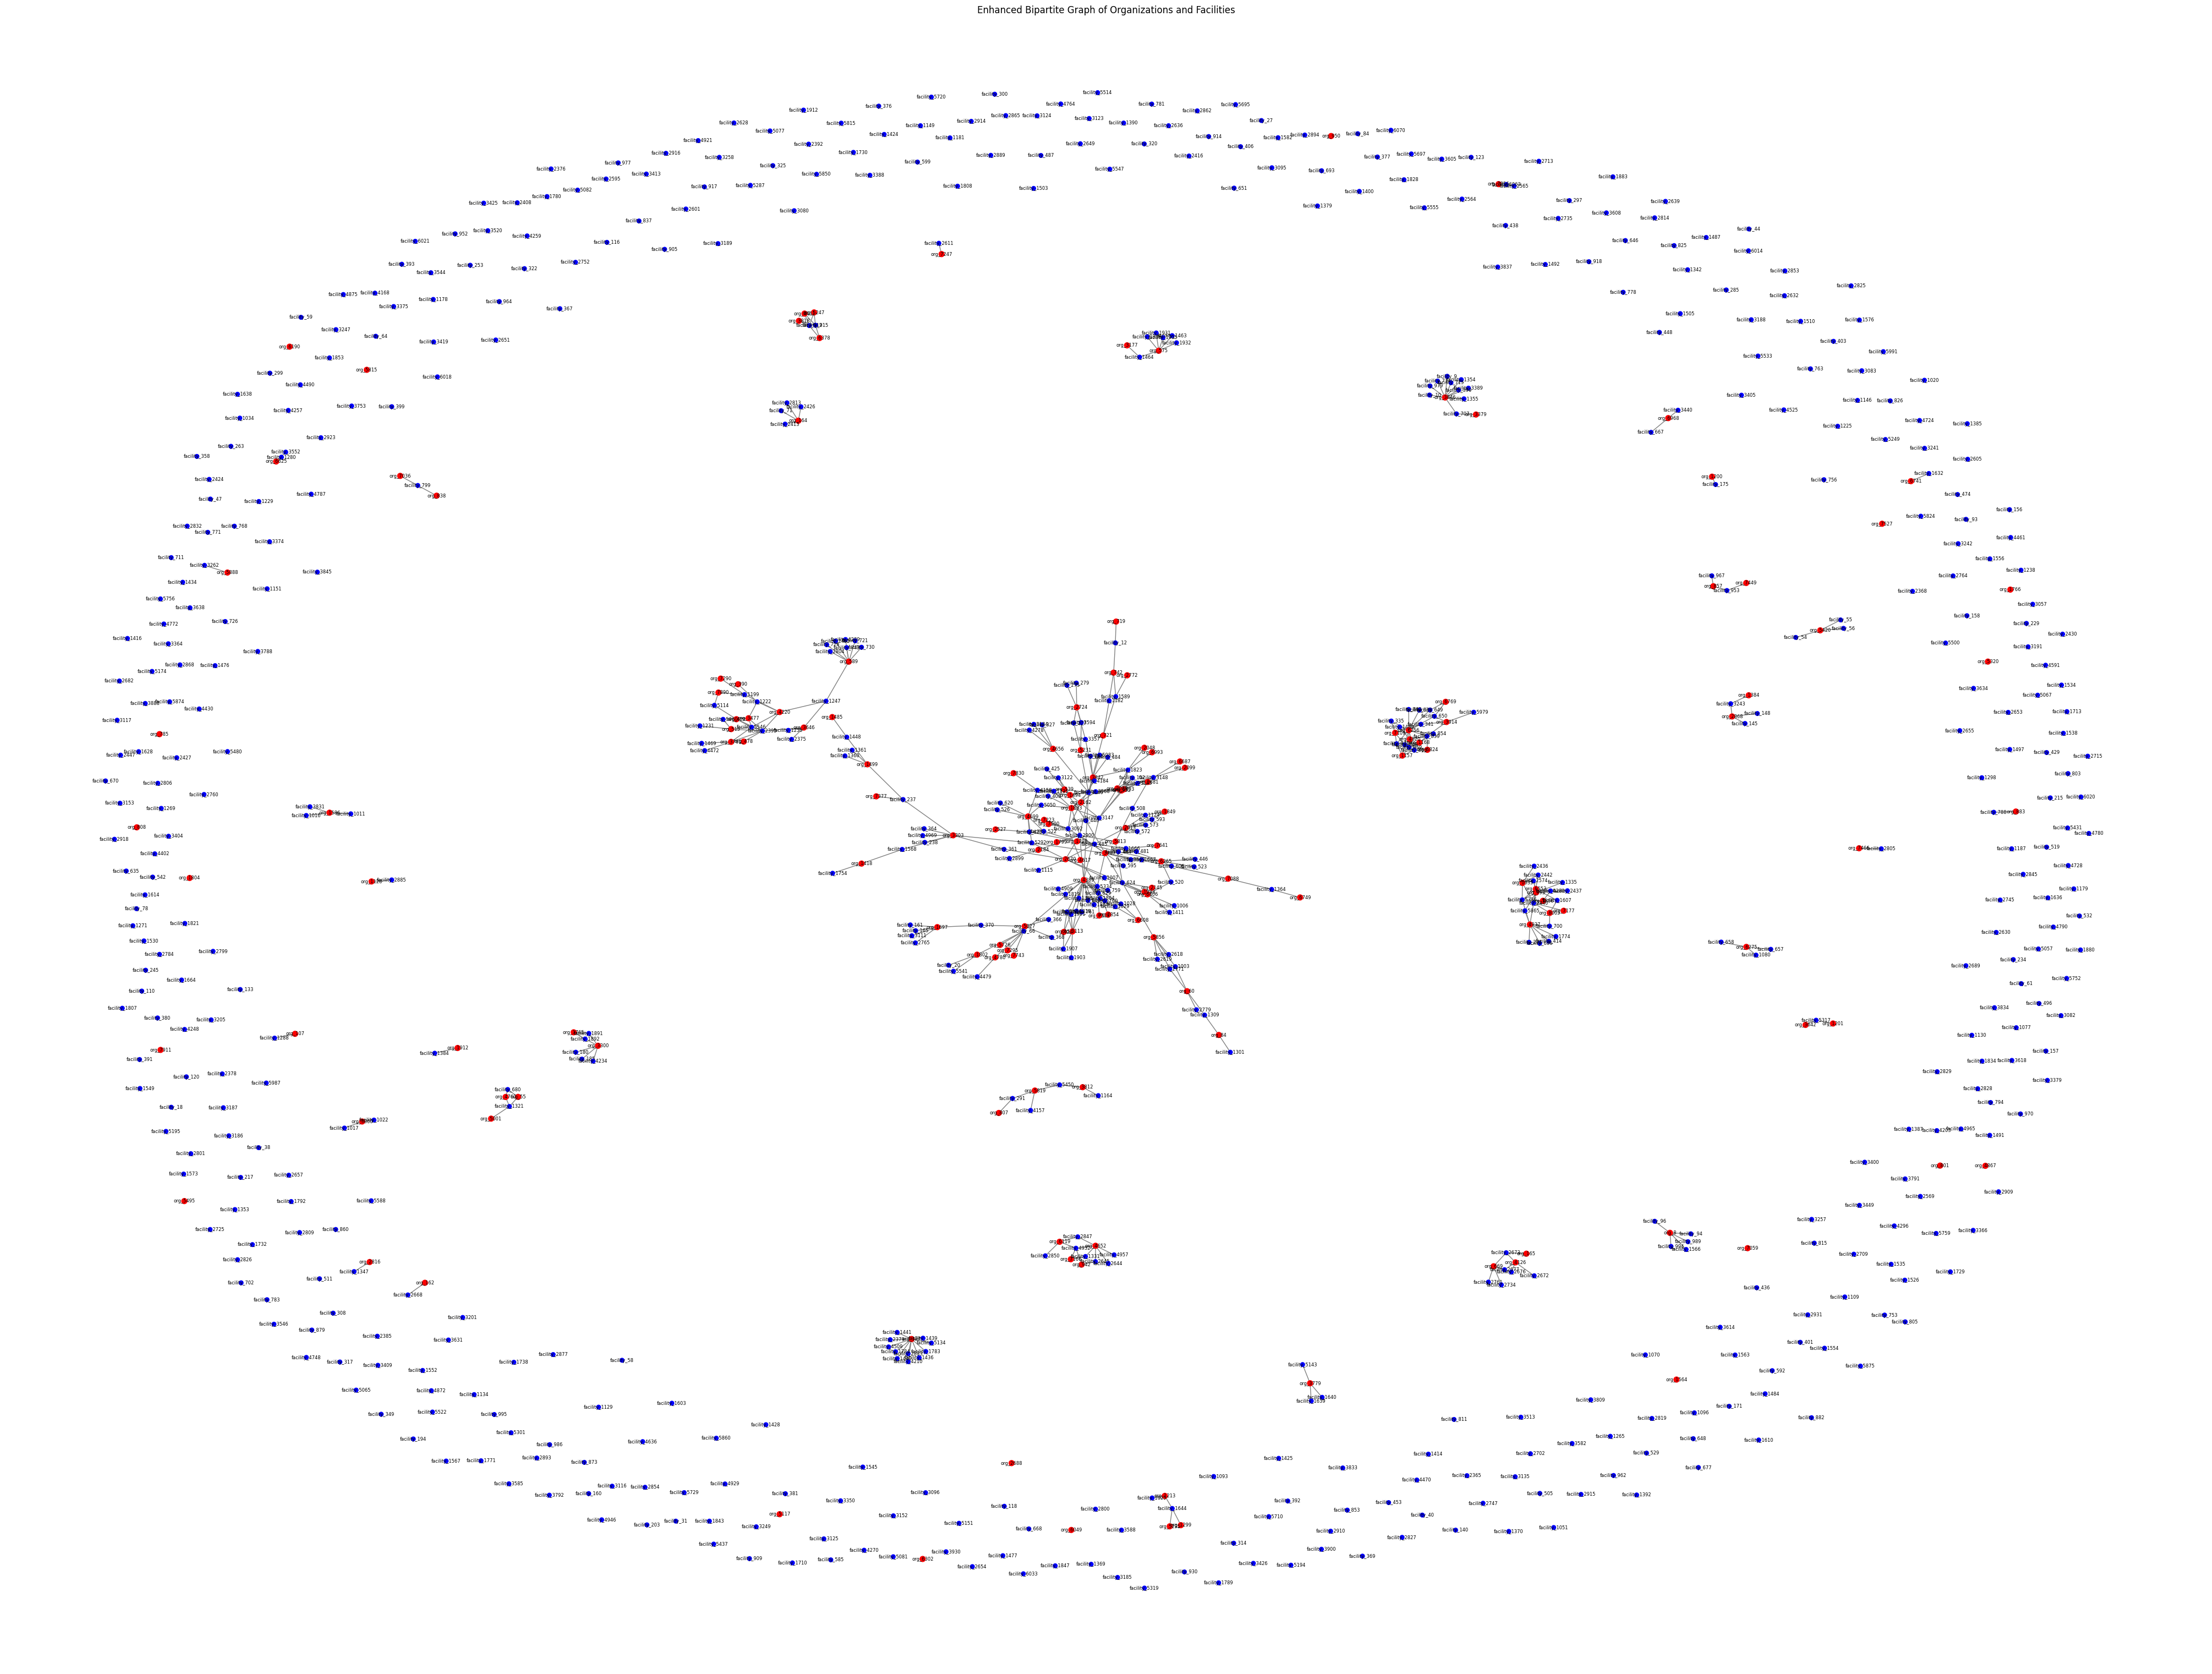

In [14]:
# Convert node identifiers to strings
B = nx.relabel_nodes(B, {n: str(n) for n in B.nodes})

# Assign colors based on node type
color_map = []
size_map = []
for node in B:
    if 'org_' in node:
        color_map.append('red')
        size_map.append(50)
    else:
        color_map.append('blue')
        size_map.append(30)

# Define the position using spring layout
pos = nx.spring_layout(B, seed=42)

# Draw the bipartite graph with enhanced visualization
plt.figure(figsize=(40, 30))
nx.draw(B, pos, with_labels=True, node_size=size_map, font_size=6, node_color=color_map, edge_color='gray')
plt.title("Enhanced Bipartite Graph of Organizations and Facilities")
plt.show()

In [48]:
B = nx.Graph()

# Add nodes for organizations with coordinates
for index, row in filtered_data_org.iterrows():
    B.add_node(f'org_{row["org_id"]}', bipartite=1, label=row['nimi'], 
               latitude=row['kaart_laius'], longitude=row['kaart_pikkus'])

# Add nodes for activity locations (facilities)
for index, row in filtered_data_fac.iterrows():
    B.add_node(f'facility_{row["rajatisid"]}', bipartite=0, label=row['rajatisnimi'],
               latitude=row['kaart_laius'], longitude=row['kaart_pikkus'])

# Add edges based on the relationships
for index, row in filtered_data_org.iterrows():
    if pd.notna(row['location_name']):
        org_node = f'org_{row["org_id"]}'
        facility_node_df = filtered_data_fac[filtered_data_fac['rajatisnimi'] == row['location_name']]
        if not facility_node_df.empty:
            facility_node = f'facility_{facility_node_df["rajatisid"].values[0]}'
            B.add_edge(org_node, facility_node)

# Validate the bipartite nature
if nx.is_bipartite(B):
    print("The graph is bipartite.")
else:
    print("The graph is not bipartite. Checking for issues...")

# Print number of nodes and edges
print(f"Number of nodes: {B.number_of_nodes()}")
print(f"Number of edges: {B.number_of_edges()}")

# Visualize the bipartite graph with labels
plt.figure(figsize=(20, 15))
pos = nx.spring_layout(B, seed=42)

# Draw nodes
org_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 1}
facility_nodes = set(B) - org_nodes

# Calculate degree for each facility node
facility_degrees = dict(B.degree(facility_nodes))

# Adjust node size based on degree (number of connections)
facility_sizes = [facility_degrees[n] * 50 for n in facility_nodes]  # Scaling factor for visibility

nx.draw_networkx_nodes(B, pos, nodelist=org_nodes, node_color='red', node_size=100, label='Organizations')
nx.draw_networkx_nodes(B, pos, nodelist=facility_nodes, node_color='blue', node_size=facility_sizes, label='Facilities')  # Larger size for facilities based on degree
nx.draw_networkx_edges(B, pos, edgelist=B.edges, edge_color='gray')


# Sort facility nodes by degree and select top 5
top_facilities = sorted(facility_degrees, key=facility_degrees.get, reverse=True)[:5]

# Draw labels for top 5 facilities only
facility_labels = {n: B.nodes[n]['label'] for n in top_facilities}
nx.draw_networkx_labels(B, pos, labels=facility_labels, font_size=12)

plt.title("Bipartite Graph of Organizations and Facilities")
plt.legend()
plt.show()


The graph is bipartite.
Number of nodes: 5851
Number of edges: 4292


In [49]:
nx.write_graphml(B, "bipartite_graph_all_sports.graphml")

## Network Analysis

In [200]:
components = list(nx.connected_components(B))
sorted_components = sorted(components, key=len, reverse=True)

# Select the top 10 largest components
top_components = sorted_components[:20]

# Create subgraphs for the top 10 largest components
subgraphs = [B.subgraph(component) for component in top_components]

# Combine all subgraphs into one plot
combined_subgraph = nx.Graph()

# Add nodes and edges from each subgraph to the combined graph
for subgraph in subgraphs:
    combined_subgraph.add_nodes_from(subgraph.nodes(data=True))
    combined_subgraph.add_edges_from(subgraph.edges(data=True))

# Print number of nodes and edges
print(f"Number of nodes: {combined_subgraph.number_of_nodes()}")
print(f"Number of edges: {combined_subgraph.number_of_edges()}")

Number of nodes: 209
Number of edges: 235


In [201]:
# Visualize the bipartite graph with labels
plt.figure(figsize=(40, 30))
pos = nx.spring_layout(combined_subgraph, seed=42)

# Draw nodes
org_nodes = {n for n, d in combined_subgraph.nodes(data=True) if d.get('bipartite') == 1}
facility_nodes = set(combined_subgraph) - org_nodes

nx.draw_networkx_nodes(combined_subgraph, pos, nodelist=org_nodes, node_color='red', node_size=100, label='Organizations')
nx.draw_networkx_nodes(combined_subgraph, pos, nodelist=facility_nodes, node_color='blue', node_size=200, label='Facilities')  # Larger size for facilities
nx.draw_networkx_edges(combined_subgraph, pos, edgelist=combined_subgraph.edges, edge_color='gray')

# Draw labels for facilities only
facility_labels = {n: d['label'] for n, d in combined_subgraph.nodes(data=True) if n in facility_nodes}
nx.draw_networkx_labels(combined_subgraph, pos, labels=facility_labels, font_size=6)

plt.title("Bipartite Graph of Organizations and Facilities")
plt.legend()
plt.show()

### Degree centrality

In [202]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Extract the facilities nodes
facility_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 0}

# Calculate degree centrality for facilities
degree_centrality = nx.degree_centrality(B)
facility_degree_centrality = {n: degree_centrality[n] for n in facility_nodes}

# Calculate betweenness centrality for facilities
betweenness_centrality = nx.betweenness_centrality(B)
facility_betweenness_centrality = {n: betweenness_centrality[n] for n in facility_nodes}

# Calculate closeness centrality for facilities
closeness_centrality = nx.closeness_centrality(B)
facility_closeness_centrality = {n: closeness_centrality[n] for n in facility_nodes}

# Convert the results to a DataFrame with facility names
centrality_df = pd.DataFrame({
    'facility': [B.nodes[n]['label'] for n in facility_nodes],
    'degree_centrality': [facility_degree_centrality[n] for n in facility_nodes],
    'betweenness_centrality': [facility_betweenness_centrality[n] for n in facility_nodes],
    'closeness_centrality': [facility_closeness_centrality[n] for n in facility_nodes]
})

In [203]:
# Sort the DataFrame by degree centrality to find the most connected facilities
centrality_df = centrality_df.sort_values(by='degree_centrality', ascending=False)

# Display the DataFrame
# print(centrality_df.head(10))

# Plot the degree centrality for visualization
plt.figure(figsize=(15, 10))
plt.bar(centrality_df['facility'][:10], centrality_df['degree_centrality'][:10], color='blue')
plt.xlabel('Facility')
plt.ylabel('Degree Centrality')
plt.title('Top 10 Facilities by Degree Centrality')
plt.xticks(rotation=90)
plt.show()

In [204]:
# Calculate the degree centrality for each node
degree_centrality = nx.degree_centrality(B)

# Convert degree centrality to a DataFrame
degree_centrality_df = pd.DataFrame(list(degree_centrality.items()), columns=['Node', 'Degree Centrality'])

# Count the number of nodes with zero degree centrality
zero_degree_count = (degree_centrality_df['Degree Centrality'] == 0).sum()

# Calculate other statistics
mean_degree_centrality = degree_centrality_df['Degree Centrality'].mean()
median_degree_centrality = degree_centrality_df['Degree Centrality'].median()
std_degree_centrality = degree_centrality_df['Degree Centrality'].std()
min_degree_centrality = degree_centrality_df['Degree Centrality'].min()
max_degree_centrality = degree_centrality_df['Degree Centrality'].max()

# Display the results
print(f"Number of nodes with zero degree centrality: {zero_degree_count}")
print(f"Mean degree centrality: {mean_degree_centrality}")
print(f"Median degree centrality: {median_degree_centrality}")
print(f"Standard deviation of degree centrality: {std_degree_centrality}")
print(f"Minimum degree centrality: {min_degree_centrality}")
print(f"Maximum degree centrality: {max_degree_centrality}")

# Convert to DataFrame for better visualization
degree_centrality_stats = {
    'Statistic': ['Count', 'Mean', 'Median', 'Standard Deviation', 'Minimum', 'Maximum'],
    'Value': [zero_degree_count, mean_degree_centrality, median_degree_centrality, std_degree_centrality, min_degree_centrality, max_degree_centrality]
}


Number of nodes with zero degree centrality: 185
Mean degree centrality: 0.0028819124560035903
Median degree centrality: 0.0024330900243309003
Standard deviation of degree centrality: 0.004076960631643246
Minimum degree centrality: 0.0
Maximum degree centrality: 0.026763990267639905


In [205]:
### KASUTAB CENTRALITY MÕÕTMISEKS AINULT FACILITY

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the graph is bipartite
assert nx.is_bipartite(B), "The graph is not bipartite."

# Extract the facilities and organizations nodes
facility_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 0}
organization_nodes = set(B) - facility_nodes

# Calculate bipartite degree centrality for facilities
degree_centrality = nx.bipartite.degree_centrality(B, facility_nodes)

# Calculate bipartite betweenness centrality for facilities
betweenness_centrality = nx.bipartite.betweenness_centrality(B, facility_nodes)

# Calculate bipartite closeness centrality for facilities
closeness_centrality = nx.bipartite.closeness_centrality(B, facility_nodes)

# Convert the results to a DataFrame with facility names
centrality_df = pd.DataFrame({
    'facility': [B.nodes[n]['label'] for n in facility_nodes],
    'degree_centrality': [degree_centrality[n] for n in facility_nodes],
    'betweenness_centrality': [betweenness_centrality[n] for n in facility_nodes],
    'closeness_centrality': [closeness_centrality[n] for n in facility_nodes]
})

# Sort the DataFrame by degree centrality to find the most connected facilities
centrality_df = centrality_df.sort_values(by='degree_centrality', ascending=False)

# Display the DataFrame
print(centrality_df.head(10))

# Plot the degree centrality for visualization
plt.figure(figsize=(15, 10))
plt.bar(centrality_df['facility'][:10], centrality_df['degree_centrality'][:10], color='blue')
plt.xlabel('Facility')
plt.ylabel('Degree Centrality')
plt.title('Top 10 Facilities by Degree Centrality')
plt.xticks(rotation=90)
plt.show()


                                              facility  degree_centrality  \
110                                 ejli jalgpallihall           0.067485   
76    sõle spordikeskuse jalgpalliväljak/jalgpallihall           0.055215   
126                           õismäe sportmängude hall           0.042945   
97                           wismari jalgpallistaadion           0.042945   
156                                    sportland arena           0.036810   
142                                         kotka hall           0.036810   
108  kohtla-järve spordikeskuse kunstmurukattega ja...           0.036810   
52                       tartu annemõisa jalgpallihall           0.030675   
84     pärnu rehepapi kunstmurukattega jalgpalliväljak           0.030675   
248                                         nike arena           0.030675   

     betweenness_centrality  closeness_centrality  
110                0.017176              0.471001  
76                 0.022039              0.52699

### Betweenness centrality

In [206]:
# Sort the DataFrame by degree centrality to find the most connected facilities
centrality_df = centrality_df.sort_values(by='betweenness_centrality', ascending=False)

# Plot the betweenness centrality for visualization
plt.figure(figsize=(15, 10))
plt.bar(centrality_df['facility'][:10], centrality_df['betweenness_centrality'][:10], color='green')
plt.xlabel('Facility')
plt.ylabel('Betweenness Centrality')
plt.title('Top 10 Facilities by Betweenness Centrality')
plt.xticks(rotation=90)
plt.show()


### Closeness centrality

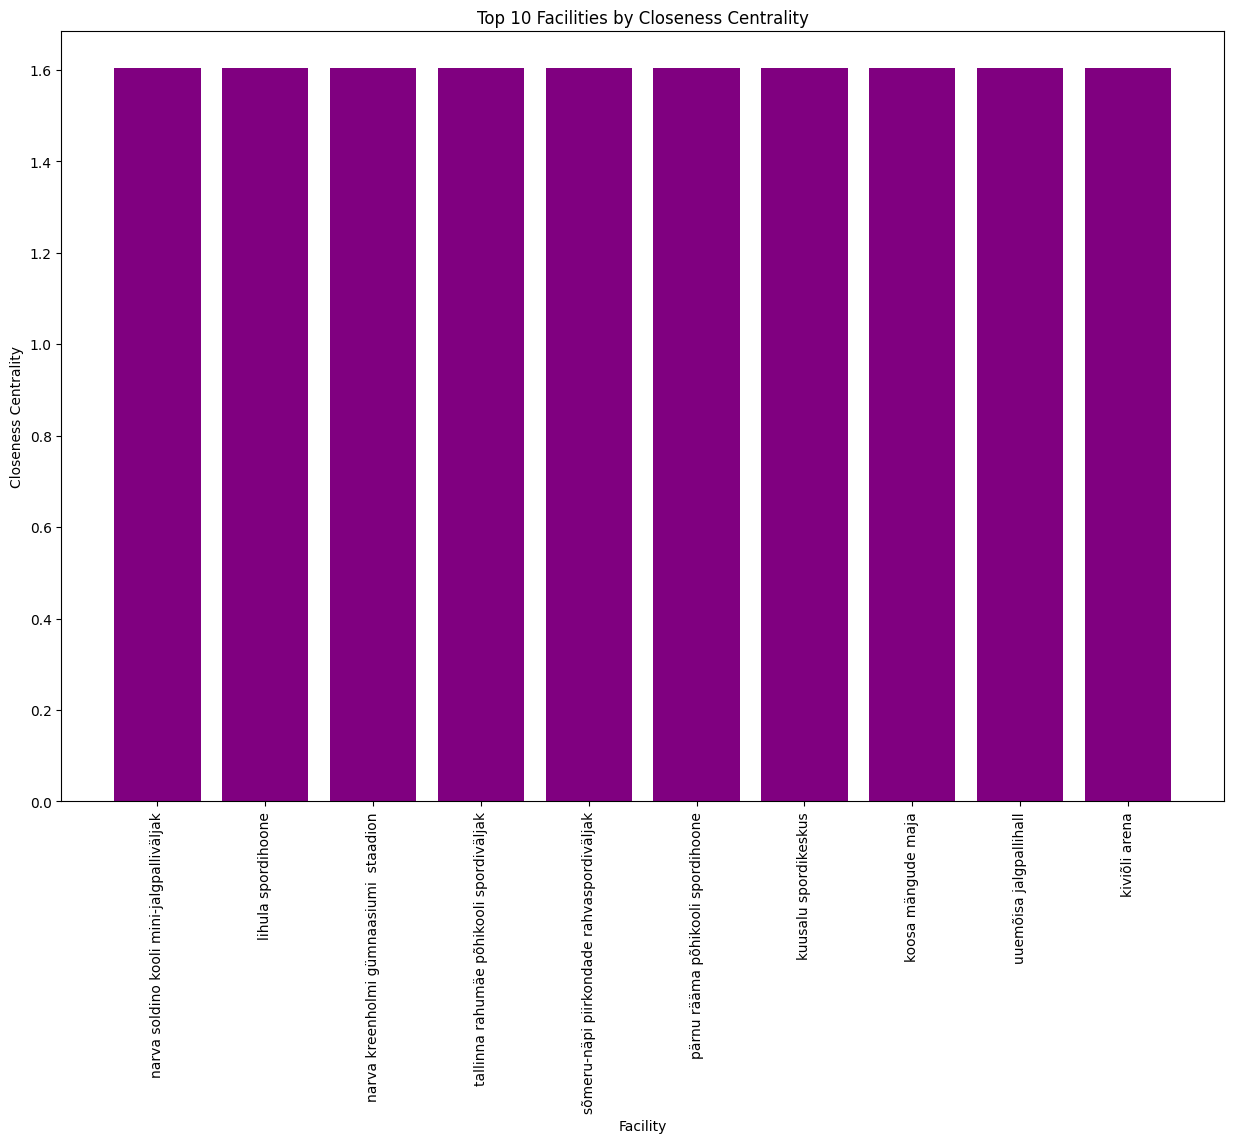

In [207]:
# Sort the DataFrame by degree centrality to find the most connected facilities
centrality_df = centrality_df.sort_values(by='closeness_centrality', ascending=False)

# Plot the closeness centrality for visualization
plt.figure(figsize=(15, 10))
plt.bar(centrality_df['facility'][:10], centrality_df['closeness_centrality'][:10], color='purple')
plt.xlabel('Facility')
plt.ylabel('Closeness Centrality')
plt.title('Top 10 Facilities by Closeness Centrality')
plt.xticks(rotation=90)
plt.show()

                                             facility  closeness_centrality
76   sõle spordikeskuse jalgpalliväljak/jalgpallihall              0.097461
110                                ejli jalgpallihall              0.087106
126                          õismäe sportmängude hall              0.084981
47                    kindluse spordihoone pneumohall              0.079639
156                                   sportland arena              0.077860
19                      football planet jalgpallihall              0.075335
97                          wismari jalgpallistaadion              0.074529
109       lasnamäe kergejõustikuhalli jalgpalliväljak              0.072968
138                ejl tallinna noorte treeningkeskus              0.072968
142                                        kotka hall              0.072968


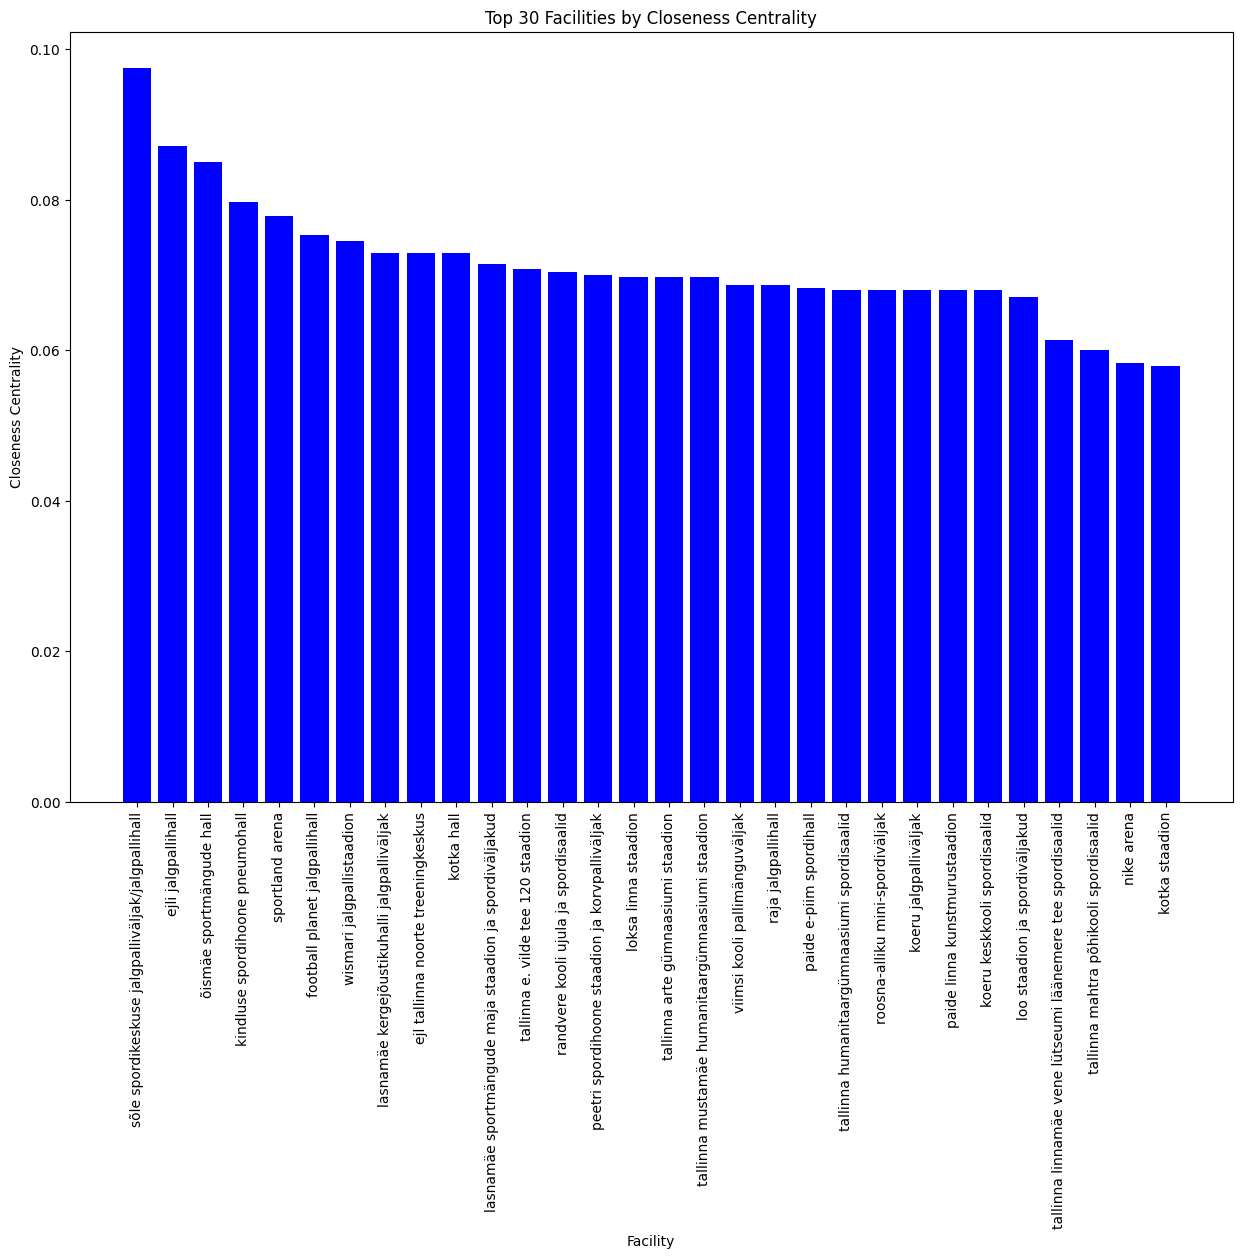

In [208]:
# UUEM VARIANT

# Ensure the graph is bipartite
assert nx.is_bipartite(B), "The graph is not bipartite."

# Extract the facilities and organizations nodes
facility_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 0}
organization_nodes = set(B) - facility_nodes

# Custom normalization for closeness centrality in bipartite graphs
def normalized_closeness_centrality(G, nodes):
    closeness_centrality = nx.closeness_centrality(G)
    normalized_centrality = {}
    for node in nodes:
        centrality = closeness_centrality[node]
        scale_factor = (len(G) - 1) / (len(G) - len(nx.descendants(G, node)) - 1)
        normalized_centrality[node] = centrality * scale_factor
    return normalized_centrality

# Calculate closeness centrality for facilities with custom normalization
facility_closeness_centrality = normalized_closeness_centrality(B, facility_nodes)

# Convert the results to a DataFrame with facility names
centrality_df = pd.DataFrame({
    'facility': [B.nodes[n]['label'] for n in facility_nodes],
    'closeness_centrality': [facility_closeness_centrality[n] for n in facility_nodes]
})

# Sort the DataFrame by closeness centrality to find the most central facilities
centrality_df = centrality_df.sort_values(by='closeness_centrality', ascending=False)

# Display the DataFrame
print(centrality_df.head(10))

# Plot the closeness centrality for visualization
plt.figure(figsize=(15, 10))
plt.bar(centrality_df['facility'][:30], centrality_df['closeness_centrality'][:30], color='blue')
plt.xlabel('Facility')
plt.ylabel('Closeness Centrality')
plt.title('Top 30 Facilities by Closeness Centrality')
plt.xticks(rotation=90)
plt.show()


### Community Detection

In [209]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import girvan_newman

# Assuming B is your bipartite graph and pos is the layout position

# Community detection using the Girvan-Newman algorithm
communities = girvan_newman(B)
top_level_communities = next(communities)
community_list = sorted(map(sorted, top_level_communities))

# Assign community labels to nodes
for i, community in enumerate(community_list):
    for node in community:
        B.nodes[node]['community'] = i

# Visualize the communities with real names as labels
color_map = []
for node in B:
    if 'community' in B.nodes[node]:
        color_map.append(B.nodes[node]['community'])
    else:
        color_map.append(0)  # Default to a neutral color if no community is assigned

# Prepare the labels with real names
labels = {n: B.nodes[n]['label'] for n in B.nodes()}

plt.figure(figsize=(40, 30))
nx.draw(B, pos, with_labels=True, labels=labels, node_size=100, font_size=6, node_color=color_map, edge_color='gray', cmap=plt.cm.jet)
plt.title("Community Detection in Bipartite Graph")
plt.show()

NetworkXError: Node 'org_1200' has no position.

In [210]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Community detection using the Girvan-Newman algorithm
from networkx.algorithms.community import girvan_newman

# Generate communities
communities = girvan_newman(B)
top_level_communities = next(communities)
community_list = sorted(map(sorted, top_level_communities))

# Assign community labels to nodes
for i, community in enumerate(community_list):
    for node in community:
        B.nodes[node]['community'] = i

# Counting the number of unique communities
unique_communities = set(nx.get_node_attributes(B, 'community').values())
num_communities = len(unique_communities)
print(f"Number of unique communities: {num_communities}")

# Determining the size of each community
community_sizes = {}
for community in unique_communities:
    community_sizes[community] = sum(1 for n in B.nodes if B.nodes[n].get('community') == community)

# Convert to DataFrame for better visualization
community_sizes_df = pd.DataFrame(list(community_sizes.items()), columns=['Community', 'Size'])
community_sizes_df = community_sizes_df.sort_values(by='Size', ascending=False)

community_sizes_df.head()

Number of unique communities: 215


Community  Size
3           3    51
1           1    44
10         10    18
65         65    14
16         16    12

In [211]:
# Calculate centrality measures within each community
community_centrality = {}
for community in unique_communities:
    subgraph = B.subgraph([n for n in B.nodes if B.nodes[n].get('community') == community])
    degree_centrality = nx.degree_centrality(subgraph)
    sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
    community_centrality[community] = sorted_degree[:5]  # Top 5 nodes by degree centrality

# Convert to DataFrame for better visualization
community_centrality_df = pd.DataFrame([
    {'Community': community, 'Node': B.nodes[node]['label'], 'Degree Centrality': centrality}
    for community, nodes in community_centrality.items()
    for node, centrality in nodes
])

community_centrality_df.head()

Community                         Node  Degree Centrality
0          0           mtü fc helios võru                0.8
1          0  rõuge põhikooli spordihoone                0.4
2          0                võru staadion                0.2
3          0            võru spordikeskus                0.2
4          0            rõuge spordiklubi                0.2

In [212]:
# Visualize the communities with real names as labels
color_map = []
for node in B:
    if 'community' in B.nodes[node]:
        color_map.append(B.nodes[node]['community'])
    else:
        color_map.append(0)  # Default to a neutral color if no community is assigned

# Prepare the labels with real names
labels = {n: B.nodes[n]['label'] for n in B.nodes()}

plt.figure(figsize=(40, 30))
pos = nx.spring_layout(B, seed=42)
nx.draw(B, pos, with_labels=True, labels=labels, node_size=100, font_size=6, node_color=color_map, edge_color='gray', cmap=plt.cm.jet)
plt.title("Community Detection in Bipartite Graph")
plt.show()

In [213]:
import networkx as nx
import matplotlib.pyplot as plt

# Calculate the degree centrality for each node
degree_centrality = nx.degree_centrality(B)

# Identify the node with the largest degree centrality in each community
community_max_centrality = {}
for node, centrality in degree_centrality.items():
    community = B.nodes[node].get('community')
    if community not in community_max_centrality:
        community_max_centrality[community] = (node, centrality)
    else:
        if centrality > community_max_centrality[community][1]:
            community_max_centrality[community] = (node, centrality)

# Prepare the labels to highlight these nodes
labels = {}
for community, (node, centrality) in community_max_centrality.items():
    labels[node] = B.nodes[node]['label']

# Visualize the graph with updated labels
color_map = [B.nodes[node]['community'] for node in B]
plt.figure(figsize=(40, 30))
pos = nx.spring_layout(B, seed=42)
nx.draw(B, pos, with_labels=True, labels=labels, node_size=100, font_size=6, node_color=color_map, edge_color='gray', cmap=plt.cm.jet)
plt.title("Community Detection in Bipartite Graph with Nodes of Largest Degree Centrality Highlighted")
plt.show()
